In [1]:
%load_ext jupyter_cms

In [ ]:
# <help>
print("I am also included in the help")

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import itertools
import matplotlib
import os
from Bio import SeqIO
from Bio import SeqUtils
import matplotlib.cm as cm
from ete3 import NCBITaxa
import re

In [2]:
def make_contig_df(contig_path, contig_name):
    """
    Make contig Dataframe from fasta file.
    """    
    f_handle = open(contig_path+'/'+contig_name, mode='r')
    contigs = SeqIO.parse(f_handle, 'fasta')
    contig_length = []
    contig_id =[]
    contig_GC = []
    assembly_id = []
    for x in contigs:
        contig_id.append(x.id)
        contig_length.append(len(x.seq))
        contig_GC.append(SeqUtils.GC(x.seq))
        assembly_id.append(p_and_a_ctg_file_name)
    s1 = pd.Series(contig_id, name='ID')
    s2 = pd.Series(contig_length, name='Length')
    s3 = pd.Series(contig_GC, name='%GC')
    s4 = pd.Series(assembly_id, name="Assembly")
    contig_df = pd.concat([s1, s2, s3, s4], axis=1)
    f_handle.close()
    return contig_df

In [3]:
#function to add another column for P and A_contig identification to dataframe
def P_and_A_identifier(df):
    """Method to add primary and alternative contig identifier rows to FC dataframes"""
    primary_list = []
    alternative_list = []
    return_df = df.iloc[:,:]
    for x in return_df['ID']:
        if "_" in list(x):
            primary_list.append(0)
            alternative_list.append(1)
        else:
            primary_list.append(1)
            alternative_list.append(0)
    return_df["P_contig"] = pd.Series(primary_list)
    return_df["A_contig"] = pd.Series(alternative_list)
    return_df = return_df.reset_index(drop=True)
    return return_df

In [4]:
#function that compares a seed with a result dataframe. It assesses if any initial IDs are missing from the result df
#and adds them with '0' in all columns to the result df
#ADD VALUE ERROR CHECK FOR EMPTY SEED_DF
def no_hit_df_extension(seed_df, result_df):
    """function that compares a seed with a result dataframe. 
    It assesses if any initial IDs are missing from the result df
    and adds them with '0' in all columns except the ID column.
    The first column in each dataframe needs to be labled 'ID'."""
    if len(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0]))) == 0:
        #test if there actually missing values
        return pd.DataFrame()
    else:
        no_hit_sr = pd.Series(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0])))
        #make empty dataframe for no_hits
        empty = np.array([[0]*(len(result_df.columns)-1) for x in range(len(no_hit_sr))])
        no_hit_df = pd.DataFrame(empty, columns =result_df.columns[1:])
        no_hit_df[result_df.columns.tolist()[0]] = no_hit_sr
        no_hit_df = no_hit_df[result_df.columns]
        return no_hit_df

In [5]:
def coverage_df_generator(file_path, file_name, seq_type):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    coverage_df = coverage_df.sort_values(by=[coverage_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_df
#no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [6]:
def coverage_df_generator_all(file_path, file_name, seq_type, seed_df):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    This also adds the IDs for which no hits have been reported.
    It returns a sorted df on the first ID column.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    #get no hit df, append and sort
    coverage_all_df = coverage_df.append(no_hit_df_extension(seed_df, coverage_df))
    coverage_all_df = coverage_all_df.sort_values(by=[coverage_all_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_all_df
    #no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [7]:
def add_cov_to_summary(sum_df, cov_df):
    """add coverage dataframe last "Average Coverage" column to blast summary df"""
    sum_sorted_df = sum_df.sort_values(by=[sum_df.columns.tolist()[0]]).reset_index(drop=True)
    cov_sorted_df = cov_df.sort_values(by=[cov_df.columns.tolist()[0]]).reset_index(drop=True)
    if set(sum_sorted_df.iloc[:,0] == cov_sorted_df.iloc[:,0]):
        sum_sorted_df[cov_sorted_df.columns.tolist()[-1]] = cov_sorted_df.iloc[:, -1]
        return sum_sorted_df
    else: #this should be made to raise an error
        print('Dataframes do not have the same ids')

In [8]:
def tc_blast_df(blast_xml_path, blast_xml_file_name, tc_list):
    """
    Returns a df of xml blast hits of target contigs.
    """
    from Bio.Blast import NCBIXML
    f = open(blast_xml_path+'/'+blast_xml_file_name, mode='r')
    blast_rec = NCBIXML.parse(f)
    tc_blast_df = pd.DataFrame()
    for record in blast_rec:
        if record.query.split(' ')[0] in tc_list: #the split may needs to be updated based on query blastn file headers.
                                                    #THINK long initial headers not _sh_ format
            NCBI_ID = []
            title_list = []
            query_contig = []
            sbj_start = []
            score_list =[]
            length=[]
            title = record.query.split(' ')[0]
            for aln in record.alignments:
                NCBI_ID.append('|'.join(aln.title.split('|')[0:4])+'|')
                title_list.append(aln.title.split('|')[4])
                query_contig.append(title)
                sbj_start_list = []
                query_score_list =[]
                length_list = []
                for hsp in aln.hsps:
                    sbj_start_list.append(hsp.query_start)
                    query_score_list.append(hsp.expect)
                    length_list.append(hsp.align_length)
                sbj_start.append(sbj_start_list)
                score_list.append(query_score_list)
                length.append(length_list)
            result_df = pd.concat([pd.Series(query_contig, name='ID'),pd.Series(NCBI_ID, name="ID-NCBI"), pd.Series(title_list, name='Blast Hit'), pd.Series(sbj_start, name='Contig Pos Aln'), pd.Series(length, name='Aln Length'), pd.Series(score_list, name='E-value')], axis =1)
            tc_blast_df = tc_blast_df.append(result_df)
    f.close()
    tc_blast_df = tc_blast_df.reset_index(drop=True)
    return tc_blast_df

In [9]:
def tc_blast_search_df(blast_xml_path, blast_xml_file_name, tc_list, search):
    """
    Returns a df of xml blast hits of target contigs were the query title matches the 'search' pattern.
    """
    from Bio.Blast import NCBIXML
    f = open(blast_xml_path+'/'+blast_xml_file_name, mode='r')
    blast_rec = NCBIXML.parse(f)
    tc_blast_df_2 = pd.DataFrame()
    for record in blast_rec:
        if record.query.split(' ')[0] in tc_list: #the split may needs to be updated based on query blastn file headers.                                            #THINK long initial headers not _sh_ format
            NCBI_ID = []
            title_list = []
            query_contig = []
            sbj_start = []
            score_list =[]
            length=[]
            title = record.query.split(' ')[0]
            #set the search term for your favorite blast hit
            for aln in record.alignments:
                #in case the title contains pattern match entered as search string in function
                if re.search(search, aln.title.split('|')[4]):
                    NCBI_ID.append('|'.join(aln.title.split('|')[0:4])+'|')
                    title_list.append(aln.title.split('|')[4])
                    query_contig.append(title)
                    sbj_start_list = []
                    query_score_list =[]
                    length_list = []
                    for hsp in aln.hsps:
                            sbj_start_list.append(hsp.query_start)
                            query_score_list.append(hsp.expect)
                            length_list.append(hsp.align_length)
                    sbj_start.append(sbj_start_list)
                    score_list.append(query_score_list)
                    length.append(length_list)
            result_df = pd.concat([pd.Series(query_contig, name='ID'),pd.Series(NCBI_ID, name="ID-NCBI"), pd.Series(title_list, name='Blast Hit'), pd.Series(sbj_start, name='Contig Pos Aln'), pd.Series(length, name='Aln Length'), pd.Series(score_list, name='E-value')], axis =1)
            tc_blast_df_2 = tc_blast_df_2.append(result_df)
            result_df = pd.DataFrame()
    f.close()
    tc_blast_df_2 = tc_blast_df_2.reset_index(drop=True)
    return tc_blast_df_2

In [10]:
def print_first_5_blast_hits(blast_xml_df):
    """
    Does what is says in conjungtion with tc_blast_df.
    """
    #set count and read in first row
    count = 0
    previous = blast_xml_df.loc[0,'ID']
    #iterarte over each row and print the long blast_xml description until you reach #5
    for index,row in blast_xml_df.iterrows():
        if row['ID'] == previous:
            count += 1
            #print(count)
        if count < 6: 
            print(blast_xml_df.loc[index, 'ID'], '\t', blast_xml_df.loc[index, 'Blast Hit'])
        if row['ID'] != previous:
            count = 0
        previous = row['ID']

In [11]:
def print_all_blast_hits(blast_xml_df):
    """
    Does what is says in conjungtion with tc_blast_df.
    """
    #set count and read in first row
    count = 0
    previous = blast_xml_df.loc[0,'ID']
    #iterarte over each row and print all blast hits
    for index,row in blast_xml_df.iterrows():
        print(blast_xml_df.loc[index, 'ID'], '\t', blast_xml_df.loc[index, 'Blast Hit'])
        print("E-value",'\t', blast_xml_df.loc[index, 'E-value'])
        print("Contig Pos Aln",'\t', blast_xml_df.loc[index,'Contig Pos Aln'])


In [12]:
#outdir for saving figures
outdir = "/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished"

In [13]:
#here pull in intial unpolished query file from Falcon p_and_a_ctg and generate a dataframe
p_and_a_ctg_path ='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/'
p_and_a_ctg_file_name = 'v8_1_ph_tr_ctg.fa'
handle_1 = open(p_and_a_ctg_path+p_and_a_ctg_file_name)

In [14]:
#here enter your blast file you want to analyze in tabBS1 format
blast_tabBS1_path = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished/'
blast_tabBS1_handle = 'v8_1_ph_tr_ctg.blast.local.tabBS1.nt'


In [15]:
#here enter your blast file you want to analyze in tabBS2 format
blast_tabBS2_path = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished/'
blast_tabBS2_handle = 'v8_1_ph_tr_ctg.blast.local.tabBS2.nt'


In [16]:
#here enter in coverage files having the same IDs as seed file. This file has been produced by 'samtools bedcov'
cov_path= blast_tabBS1_path
cov_file_name= 'v8_1_ph_tr_ctg.999999999.cov'
seq_type='PacBio'

In [17]:
#here enter the illumina cov file coresponding to p_and_a_ctg_path
cov_path_2 = blast_tabBS1_path
cov_file_name_2='v8_1_ph_tr_ctg.folder_5_ete.sam.sorted.bam.999999999.cov'
seq_type_2='Illumina'

In [18]:
#here enter file name extension to xml blast file output
blast_xml_path = blast_tabBS1_path
blast_xml_file_name ='v8_1_ph_tr_ctg.blast.local.nt'

In [19]:
#make dataframe of initial query file p_and_a_ctg_df
contigs = SeqIO.parse(handle_1, 'fasta')
contig_length = []
contig_id =[]
contig_GC = []
assembly_id = []
for x in contigs:
    contig_id.append(x.id)
    contig_length.append(len(x.seq))
    contig_GC.append(SeqUtils.GC(x.seq))
    assembly_id.append(p_and_a_ctg_file_name)
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
s3 = pd.Series(contig_GC, name='%GC')
s4 = pd.Series(assembly_id, name="Assembly")
p_and_a_ctg_df = pd.concat([s1, s2, s3, s4], axis=1)
handle_1.close()

In [20]:
p_and_a_ctg_df = P_and_A_identifier(p_and_a_ctg_df)

In [21]:
#pull in blast tabBS1 file, and rename header according to tabBS1 format convention
blast_df = pd.read_csv(blast_tabBS1_path+blast_tabBS1_handle, sep='\t', header=None)
header = ['ID', 'sseqid', 'evalue', 'bitscore', 'sgi', 'sacc', 'staxids', 'sscinames', 'scomnames', 'skingdoms']
rename = dict(zip(blast_df.columns, header))
blast_df.rename(columns=rename,inplace=True)

In [22]:
#pull in blast tabBS2 file, and rename header according to tabBS2 format convention
blast_df_2 = pd.read_csv(blast_tabBS2_path+blast_tabBS2_handle, sep='\t', header=None)
header_2 = ['ID', 'sseqid', 'evalue', 'bitscore', 'qstart', 'qend', 'length', 'sgi', 'sacc', 'staxids', 'sscinames', 'scomnames', 'skingdoms']
rename_2 = dict(zip(blast_df_2.columns, header_2))
blast_df_2.rename(columns=rename_2,inplace=True)
#sort the dataframe by "ID", "qstart", "bitscore"
blast_df_2 = blast_df_2.sort_values(by=["ID",'qstart','bitscore'], ascending=False).reset_index(drop=True)
#drop everything that is identical on the start position
blast_df_2 = blast_df_2.drop_duplicates(subset=["ID", "qstart"], keep='first').reset_index(drop=True)

In [23]:
#transform the TaxiD into a kingdom (or closest possible identifier) and add this to the blast_df as 'Kingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
ncbi=  NCBITaxa()
kingdom_list = []
for x in blast_df['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[4]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df['Kingdom'] = pd.Series(kingdom_list)

In [24]:
#transform the TaxiD into a kingdom (or closest possible identifier) and add this to the blast_df as 'Kingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
ncbi=  NCBITaxa()
kingdom_list = []
for x in blast_df_2['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[4]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df_2['Kingdom'] = pd.Series(kingdom_list)

In [25]:
#transform the TaxiD into a Superkingdom (or closest possible identifier) and add this to the blast_df as 'sKingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
kingdom_list = []
for x in blast_df['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[2]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df['Superkingdom'] = pd.Series(kingdom_list)

In [26]:
#transform the TaxiD into a Superkingdom (or closest possible identifier) and add this to the blast_df as 'sKingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
kingdom_list = []
for x in blast_df_2['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[2]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df_2['Superkingdom'] = pd.Series(kingdom_list)

In [27]:
blast_df = P_and_A_identifier(blast_df)

In [28]:
no_blast_hit_df = no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [29]:
#append original blast_df with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df
blast_all_df = blast_df.append(no_blast_hit_df)
blast_all_sorted_df  = blast_all_df.sort_values(by=['ID'])[list(no_blast_hit_df.columns)].reset_index(drop=True)
len(set(blast_all_df['ID'])) ==  len(p_and_a_ctg_df)

True

In [30]:
blast_df_2 = P_and_A_identifier(blast_df_2)

In [31]:
no_blast_hit_df_2 = no_hit_df_extension(p_and_a_ctg_df, blast_df_2)

In [32]:
#append original blast_df_2 with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df_2
blast_all_df_2 = blast_df_2.append(no_blast_hit_df_2)
blast_all_sorted_df_2  = blast_all_df_2.sort_values(by=['ID'])[list(no_blast_hit_df_2.columns)].reset_index(drop=True)
len(set(blast_all_df_2['ID'])) ==  len(p_and_a_ctg_df)

True

In [33]:
#get all Superkingdoms of the dataframe and all contigs
Kingdoms = list(set(blast_all_sorted_df['Kingdom']))
contigs = sorted(list(set(blast_all_sorted_df['ID'])))

In [34]:
#get all Superkingdoms of the dataframe and all contigs
Kingdoms_2 = list(set(blast_all_sorted_df_2['Kingdom']))
contigs_2 = sorted(list(set(blast_all_sorted_df_2['ID'])))

In [35]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Kingdoms[Kingdoms.index(0)]

In [36]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Kingdoms_2[Kingdoms_2.index(0)]

In [37]:
#create a df summarizing all blast hits for each contig at the Kingdom level
list_of_summary_series =[]
overall_count = 0
for king in Kingdoms:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df.groupby('ID')['Kingdom']:
        for x in Series[1:]: #is the list of ['Kingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-King'))
blast_hit_summary_df = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_df['Total King Blast Hits'] = blast_hit_summary_df[blast_hit_summary_df.columns[0]]*0
for x in range(0, (len(Kingdoms))):
    blast_hit_summary_df['Total King Blast Hits'] = blast_hit_summary_df['Total King Blast Hits'] + blast_hit_summary_df[list(blast_hit_summary_df.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_df['%Fungi'] = np.round(blast_hit_summary_df['Fungi']/blast_hit_summary_df['Total King Blast Hits']*100, 2)
blast_hit_summary_df = blast_hit_summary_df.fillna(0)
#quick test if all went correct
len(blast_hit_summary_df['Total King Blast Hits'])- len(blast_all_sorted_df.groupby('ID')['Kingdom'])

0

In [38]:
#create a df summarizing all blast hits for each contig at the Kingdom level for reduced blast_df_2
list_of_summary_series =[]
overall_count = 0
for king in Kingdoms_2:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df_2.groupby('ID')['Kingdom']:
        for x in Series[1:]: #is the list of ['Kingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-King'))
blast_hit_summary_df_2 = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_df_2['Total King Blast Hits'] = blast_hit_summary_df_2[blast_hit_summary_df_2.columns[0]]*0
for x in range(0, (len(Kingdoms_2))):
    blast_hit_summary_df_2['Total King Blast Hits'] = blast_hit_summary_df_2['Total King Blast Hits'] + blast_hit_summary_df_2[list(blast_hit_summary_df_2.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_df_2['%Fungi'] = np.round(blast_hit_summary_df_2['Fungi']/blast_hit_summary_df_2['Total King Blast Hits']*100, 2)
blast_hit_summary_df_2 = blast_hit_summary_df_2.fillna(0)
#quick test if all went correct
len(blast_hit_summary_df_2['Total King Blast Hits'])- len(blast_all_sorted_df_2.groupby('ID')['Kingdom'])

0

In [39]:
#get all Superkingdoms of the dataframe and all contigs
Superkingdoms = list(set(blast_all_sorted_df['Superkingdom']))
contigs = sorted(list(set(blast_all_sorted_df['ID'])))

In [40]:
#get all Superkingdoms of the dataframe and all contigs
Superkingdoms_2 = list(set(blast_all_sorted_df_2['Superkingdom']))
contigs_2 = sorted(list(set(blast_all_sorted_df_2['ID'])))

In [41]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Superkingdoms_2[Superkingdoms_2.index(0)]

In [42]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Superkingdoms[Superkingdoms.index(0)]

In [43]:
#create a df summarizing all blast hits for each contig at the Superkingdom level
list_of_summary_series =[]
overall_count = 0
for king in Superkingdoms_2:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df_2.groupby('ID')['Superkingdom']:
        for x in Series[1:]: #is the list of ['Superkingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-blast'))
blast_hit_summary_SK_df_2 = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_SK_df_2['Total Blast Hits'] = blast_hit_summary_SK_df_2[blast_hit_summary_SK_df_2.columns[0]]*0
for x in range(0, (len(Superkingdoms_2))):
    blast_hit_summary_SK_df_2['Total Blast Hits'] = blast_hit_summary_SK_df_2['Total Blast Hits'] + blast_hit_summary_SK_df_2[list(blast_hit_summary_SK_df_2.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_SK_df_2['%Eukaryota'] = np.round(blast_hit_summary_SK_df_2['Eukaryota']/blast_hit_summary_SK_df_2['Total Blast Hits']*100, 2)
blast_hit_summary_SK_df_2 = blast_hit_summary_SK_df_2.fillna(0)
#quick test if all went correct
len(blast_hit_summary_SK_df_2['Total Blast Hits'])- len(blast_all_sorted_df_2.groupby('ID')['Superkingdom'])

0

In [44]:
#create a df summarizing all blast hits for each contig at the Superkingdom level
list_of_summary_series =[]
overall_count = 0
for king in Superkingdoms:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df.groupby('ID')['Superkingdom']:
        for x in Series[1:]: #is the list of ['Superkingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID-blast'))
blast_hit_summary_SK_df = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_SK_df['Total Blast Hits'] = blast_hit_summary_SK_df[blast_hit_summary_SK_df.columns[0]]*0
for x in range(0, (len(Superkingdoms))):
    blast_hit_summary_SK_df['Total Blast Hits'] = blast_hit_summary_SK_df['Total Blast Hits'] + blast_hit_summary_SK_df[list(blast_hit_summary_SK_df.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_SK_df['%Eukaryota'] = np.round(blast_hit_summary_SK_df['Eukaryota']/blast_hit_summary_SK_df['Total Blast Hits']*100, 2)
blast_hit_summary_SK_df = blast_hit_summary_SK_df.fillna(0)
#quick test if all went correct
len(blast_hit_summary_SK_df['Total Blast Hits'])- len(blast_all_sorted_df.groupby('ID')['Superkingdom'])

0

In [45]:
p_and_a_ctg_sorted_df = p_and_a_ctg_df.sort_values(by='ID').reset_index(drop=True)

In [46]:
#add the summary_df to the seed_df
p_and_a_ctg_blast_df = pd.concat([p_and_a_ctg_sorted_df, blast_hit_summary_df.sort_values(by='ID-King')], axis =1)
p_and_a_ctg_blast_df = pd.concat([p_and_a_ctg_blast_df, blast_hit_summary_SK_df.sort_values(by='ID-blast')], axis =1)

In [47]:
#add the summary_df to the seed_df
p_and_a_ctg_blast_df_2 = pd.concat([p_and_a_ctg_sorted_df, blast_hit_summary_df_2.sort_values(by='ID-King')], axis =1)
p_and_a_ctg_blast_df_2 = pd.concat([p_and_a_ctg_blast_df_2, blast_hit_summary_SK_df_2.sort_values(by='ID-blast')], axis =1)

In [48]:
#quick test if all went alright
set(p_and_a_ctg_blast_df.loc[:,'ID'] == p_and_a_ctg_blast_df.loc[:,'ID-blast'])
#p_and_a_ctg_blast_df[p_and_a_ctg_blast_df['Total Blast Hits'] == 0].count()

{True}

In [49]:
#delete the 'ID-blast' column
del p_and_a_ctg_blast_df['ID-blast']

In [50]:
#add another column to the data frame that IDs the primary associated contig
primary_ID = []
for x in p_and_a_ctg_blast_df_2['ID']:
    if "_" in list(x):
        primary_ID.append(x[0:7])
    else:
        primary_ID.append(x)
p_and_a_ctg_blast_df_2["P_ID"] = pd.Series(primary_ID)

In [51]:
#add another column to the data frame that IDs the primary associated contig
primary_ID = []
for x in p_and_a_ctg_blast_df['ID']:
    if "_" in list(x):
        primary_ID.append(x[0:7])
    else:
        primary_ID.append(x)
p_and_a_ctg_blast_df["P_ID"] = pd.Series(primary_ID)

In [52]:
#safe the reduced blastdf #2 in cwd
p_and_a_ctg_blast_df_2.to_csv(blast_tabBS1_handle+'.blast_summary_reduced.csv', sep='\t', encoding='utf-8')

In [53]:
#safe the dataframe in blast_tabBS1_handle dir
p_and_a_ctg_blast_df.to_csv(blast_tabBS1_handle+'.blast_summary.csv', sep='\t', encoding='utf-8')

In [54]:
#append original cov_ with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df
cov_all_df = coverage_df_generator_all(cov_path, cov_file_name, 'PacBio', p_and_a_ctg_df)
cov_all_sorted_df  = cov_all_df.sort_values(by=[cov_all_df.columns.tolist()[0]]).reset_index(drop=True)
len(set(cov_all_sorted_df.iloc[:,0])) ==  len(p_and_a_ctg_df)

True

In [55]:
#add the PacBio coverage to the p_and_a_ctg_bast_df
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_df, cov_all_sorted_df)

In [56]:
#add the PacBio coverage to the p_and_a_ctg_bast_df
p_and_a_ctg_blast_cov_df_2 = add_cov_to_summary(p_and_a_ctg_blast_df_2, cov_all_sorted_df)

In [57]:
#add the Illumina coverage
cov_contig_illumina = coverage_df_generator_all(cov_path_2, cov_file_name_2, seq_type_2, p_and_a_ctg_df)
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_cov_df, cov_contig_illumina)

In [58]:
#add the Illumina coverage
cov_contig_illumina = coverage_df_generator_all(cov_path_2, cov_file_name_2, seq_type_2, p_and_a_ctg_df)
p_and_a_ctg_blast_cov_df_2 = add_cov_to_summary(p_and_a_ctg_blast_cov_df_2, cov_contig_illumina)

In [59]:
#safe the dataframe in cwd
p_and_a_ctg_blast_cov_df.to_csv(p_and_a_ctg_file_name+'.blast_cov_summary.csv', sep='\t', encoding='utf-8')

In [60]:
#safe the dataframe in cwd
p_and_a_ctg_blast_cov_df_2.to_csv(p_and_a_ctg_file_name+'.blast_cov_summary_reduced.csv', sep='\t', encoding='utf-8')

In [61]:
p_and_a_ctg_blast_cov_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Bangiophyceae,Tsukubamonadidae,Thermotogae,delta/epsilon subdivisions,...,environmental samples,Archaea,Bacteria,Eukaryota,synthetic construct,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
0,000000F,3534678,44.149283,v8_1_ph_tr_ctg.fa,1,0,0,0,0,0,...,1,0,0,892,0,893,99.89,000000F,54.980,59.363
1,000000F_002,310052,43.811038,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,59,0,59,100.00,000000F,52.731,57.596
2,000000F_003,112863,43.687480,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,42.856,50.840
3,000000F_004,27485,42.517737,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,17.175,38.320
4,000000F_005,333604,44.459599,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,744,0,744,100.00,000000F,52.828,55.279


In [62]:
#example for getting blast results of interesting contigs
Eu_smaller_70_list = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Eukaryota']<70)]['ID'].tolist()
Eu_smaller_70_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, Eu_smaller_70_list)

In [63]:
#example to print the first 5 blast hits of each of those interesting contigs
print_first_5_blast_hits(Eu_smaller_70_blast_df)

000029F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_20816), mRNA
000029F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_02338), mRNA
000029F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_15627), mRNA
000029F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 nonsense-mediated mRNA decay protein 3 (PGTG_16280), mRNA
000029F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 nonsense-mediated mRNA decay protein 3 (PGTG_03805), mRNA


(0, 60)

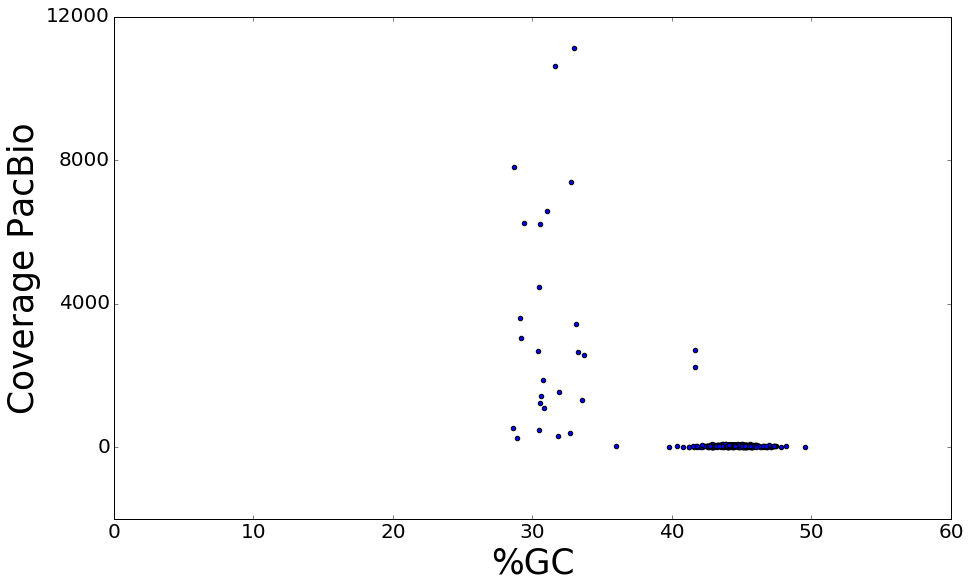

In [64]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'xx-large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'xx-large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Coverage PacBio', **label_config_y)
plt.yticks(range(0,14000,4000))
plt.xlim(0,60)
#plt.savefig(outdir+'/'+)

(0, 60)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


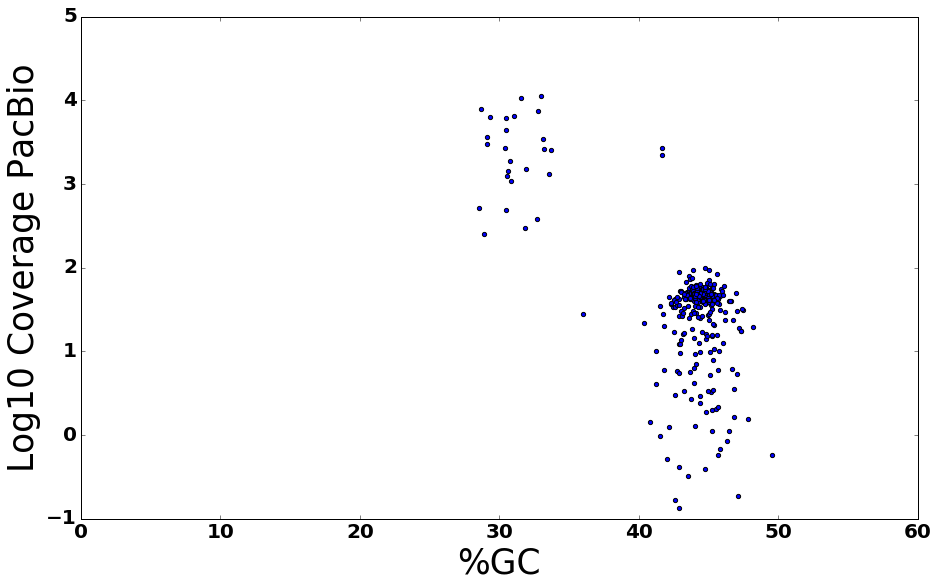

In [65]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage PacBio']), s=18)
matplotlib.rc('font', **font) #changes font of the plot
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Log10 Coverage PacBio', **label_config_y)
plt.ylim(-1,5)
plt.xlim(0,60)

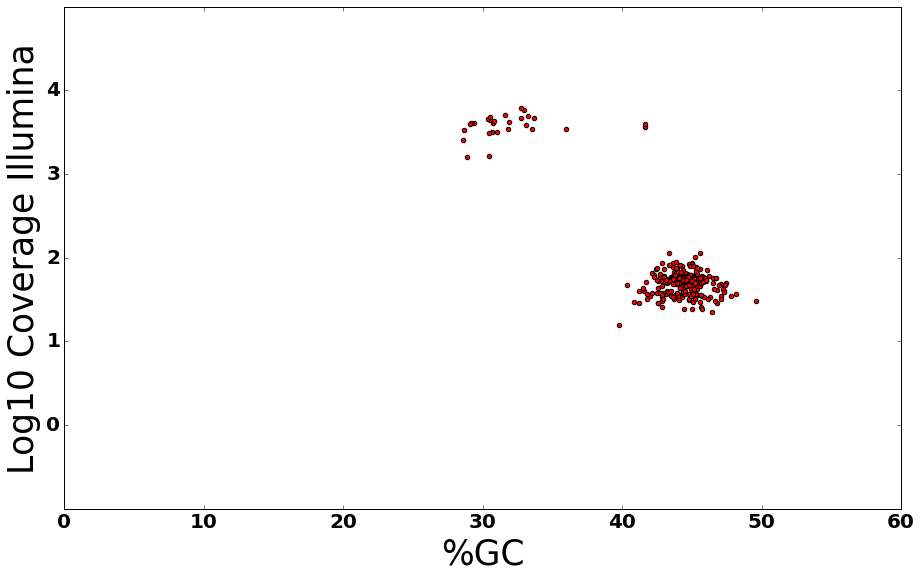

In [66]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage Illumina']), c='r')
matplotlib.rc('font', **font) #changes font of the plot
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Log10 Coverage Illumina', **label_config_y)

plt.xlim(0,60)
plt.ylim(-1,5)
plt.yticks(range(0,5,1))
plt.savefig(outdir+'/log10_Illumina_cov_cgt.png' ,dpi=300)

(0, 60)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


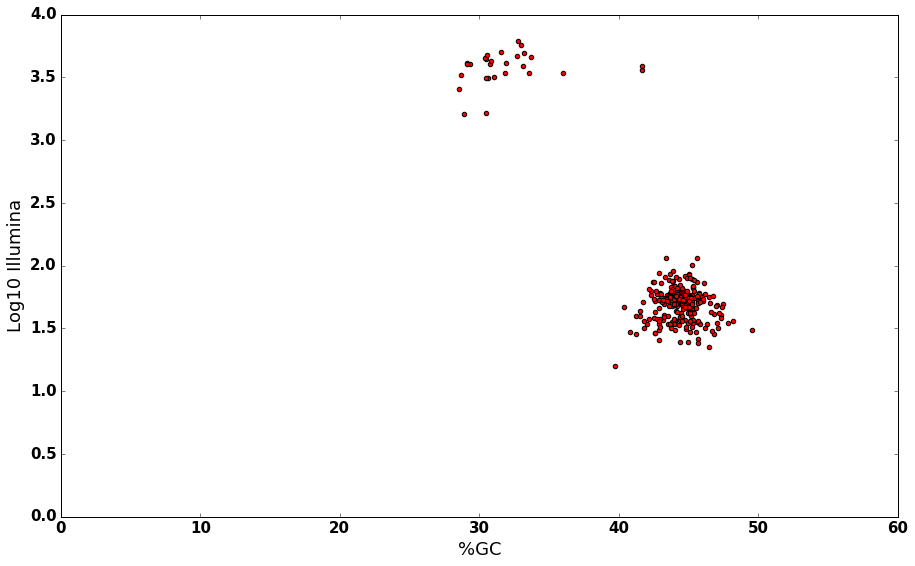

In [67]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage Illumina']),  c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Log10 Illumina', **label_config_y)
plt.ylim(0,4)
plt.xlim(0,60)

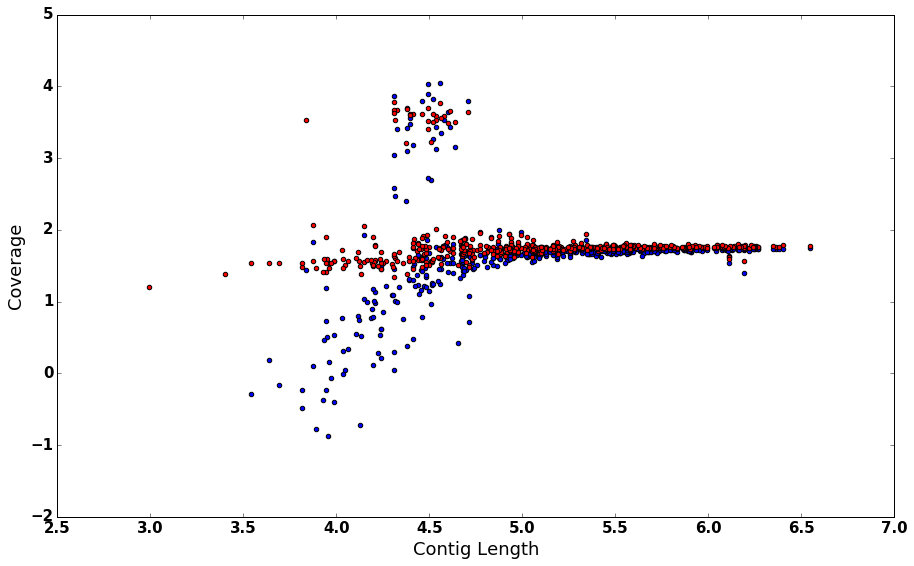

In [68]:
#contig_length vs Coverage
plt.figure(figsize=(15,9))
plt.scatter(y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage PacBio']), x=np.log10(p_and_a_ctg_blast_cov_df['Length']))
plt.scatter(y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage Illumina']), x=np.log10(p_and_a_ctg_blast_cov_df['Length']), c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('Coverage', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,14000)

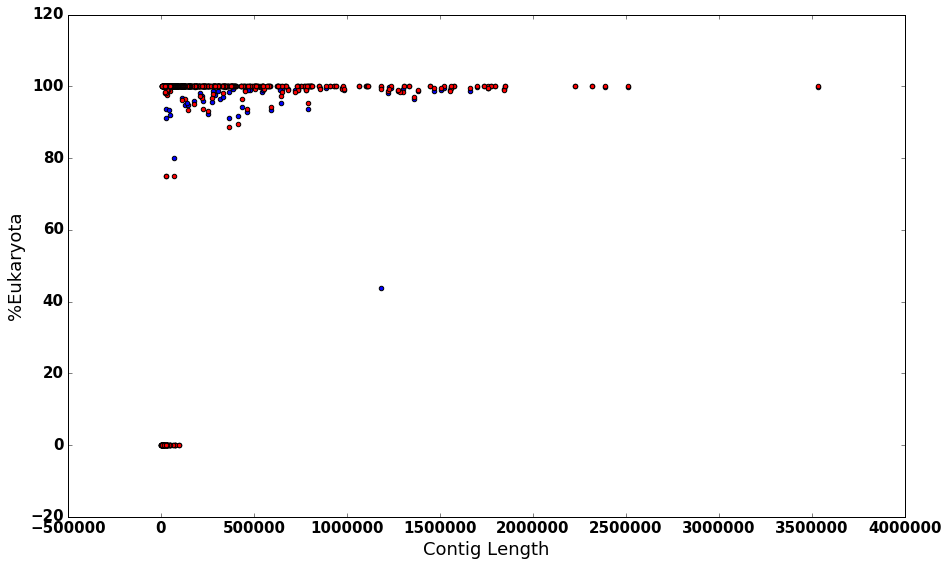

In [69]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Length'], y=p_and_a_ctg_blast_cov_df['%Eukaryota'])
plt.scatter(x=p_and_a_ctg_blast_cov_df_2['Length'], y=p_and_a_ctg_blast_cov_df_2['%Eukaryota'], c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Eukaryota', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

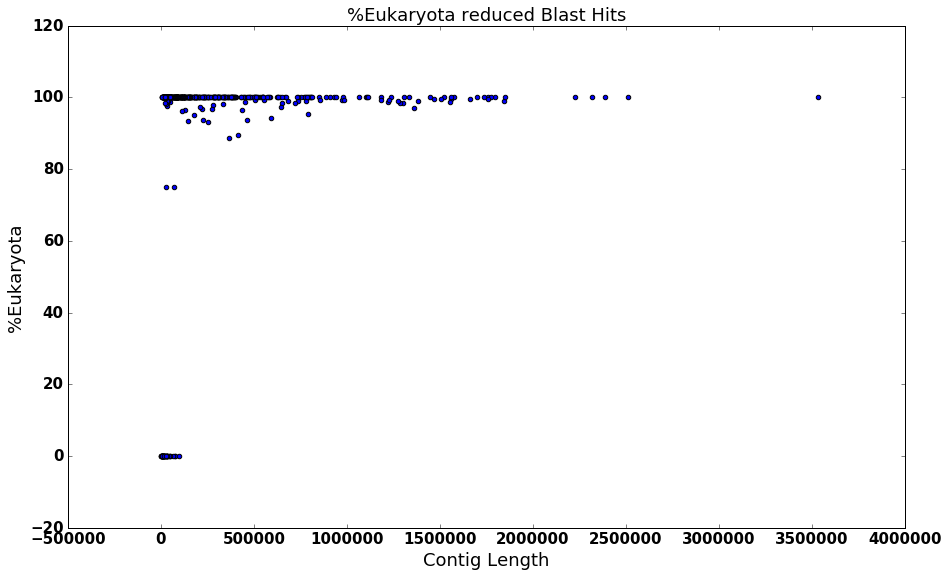

In [70]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df_2['Length'], y=p_and_a_ctg_blast_cov_df_2['%Eukaryota'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Eukaryota', **label_config_y)
plt.title("%Eukaryota reduced Blast Hits")
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

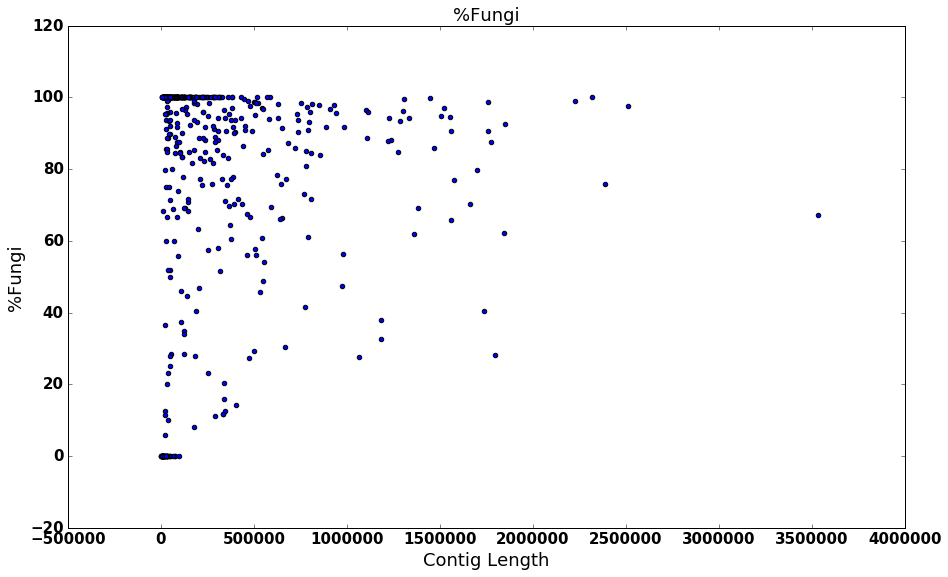

In [71]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Length'], y=p_and_a_ctg_blast_cov_df['%Fungi'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
plt.title("%Fungi")
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

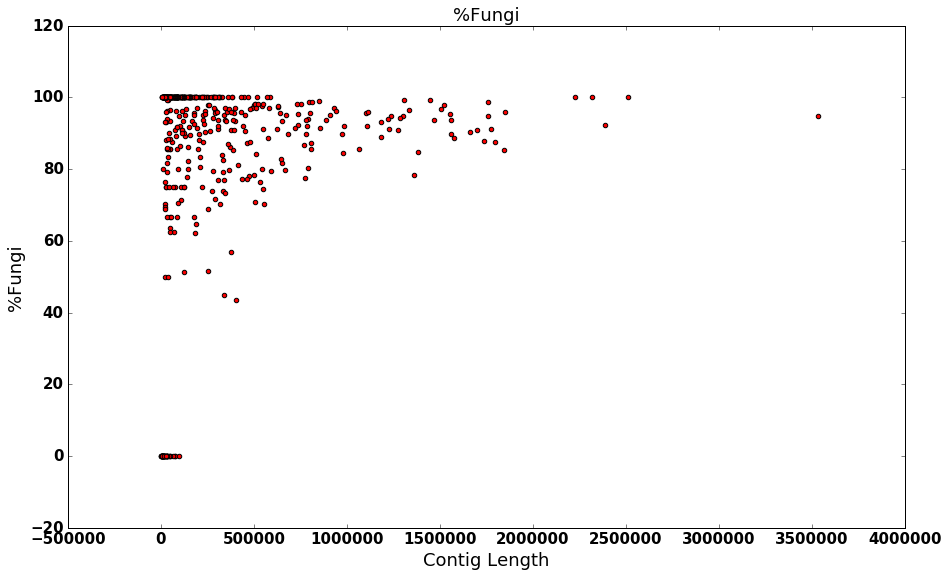

In [72]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df_2['Length'], y=p_and_a_ctg_blast_cov_df_2['%Fungi'], c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
plt.title("%Fungi")
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

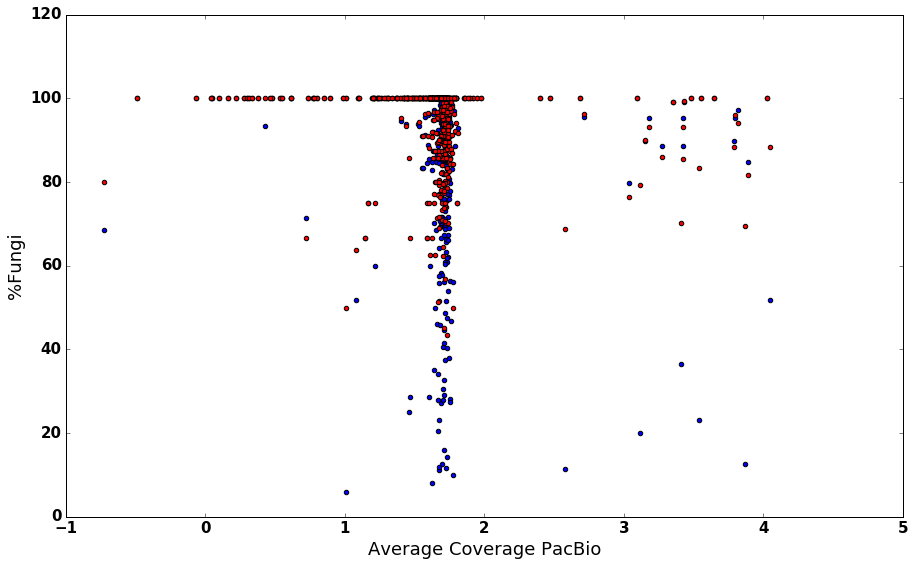

In [73]:
plt.figure(figsize=(15,9))
plt.scatter(x=np.log10(p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['Average Coverage PacBio']), y=p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['%Fungi'])
plt.scatter(x=np.log10(p_and_a_ctg_blast_cov_df_2[p_and_a_ctg_blast_cov_df_2['Total Blast Hits'] >0]['Average Coverage PacBio']), y=p_and_a_ctg_blast_cov_df_2[p_and_a_ctg_blast_cov_df_2['Total Blast Hits'] >0]['%Fungi'], c='r')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Average Coverage PacBio", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

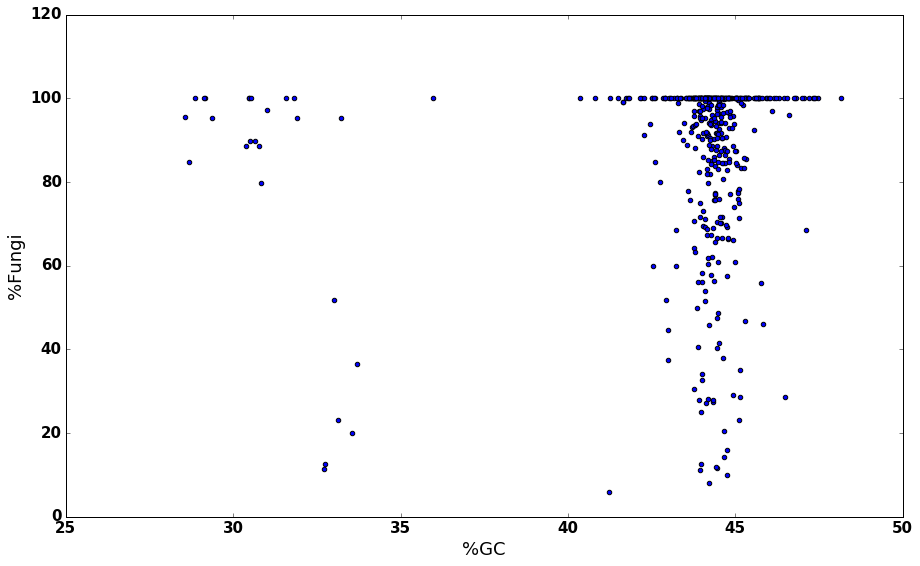

In [74]:
plt.figure(figsize=(15,9))
plt.scatter(x=(p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['%GC']), y=p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0]['%Fungi'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("%GC", **label_config_x)
plt.ylabel('%Fungi', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

In [75]:
cov_contig_illumina = coverage_df_generator(cov_path_2, cov_file_name_2, seq_type_2)

In [76]:
cov_contig_illumina.head()

,ID-cov Illumina,start Illumina,stop Illumina,total hits Illumina,Average Coverage Illumina
0,000000F,0,3534678,209828904,59.363
1,000000F_002,0,310052,17857797,57.596
2,000000F_003,0,112863,5737984,50.840
3,000000F_004,0,27485,1053226,38.320
4,000000F_005,0,333604,18441271,55.279


In [77]:
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_cov_df, cov_contig_illumina)

In [78]:
p_and_a_ctg_blast_cov_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Bangiophyceae,Tsukubamonadidae,Thermotogae,delta/epsilon subdivisions,...,environmental samples,Archaea,Bacteria,Eukaryota,synthetic construct,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
0,000000F,3534678,44.149283,v8_1_ph_tr_ctg.fa,1,0,0,0,0,0,...,1,0,0,892,0,893,99.89,000000F,54.980,59.363
1,000000F_002,310052,43.811038,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,59,0,59,100.00,000000F,52.731,57.596
2,000000F_003,112863,43.687480,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,42.856,50.840
3,000000F_004,27485,42.517737,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,17.175,38.320
4,000000F_005,333604,44.459599,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,744,0,744,100.00,000000F,52.828,55.279


//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


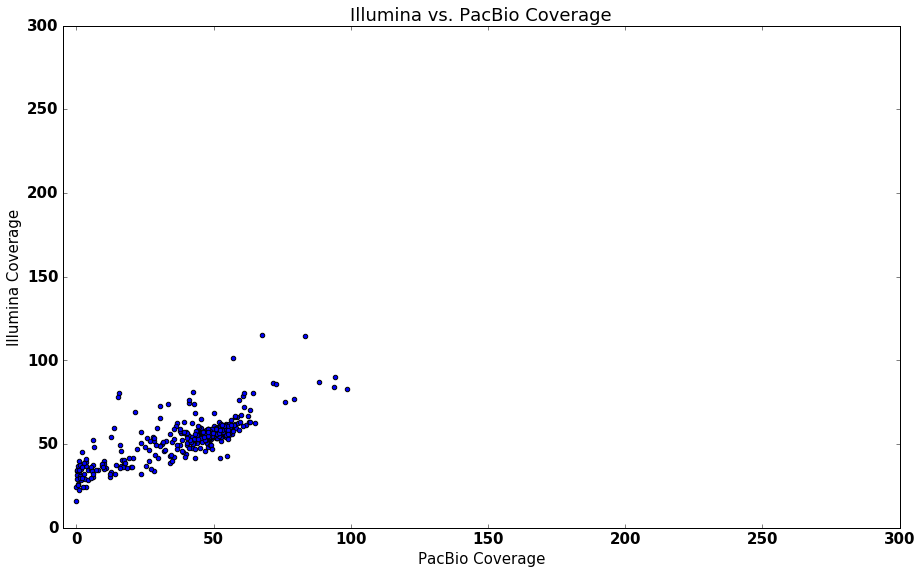

In [79]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'], y=p_and_a_ctg_blast_cov_df['Average Coverage Illumina'])
plt.ylabel("Illumina Coverage")
plt.xlabel("PacBio Coverage")
plt.xlim(-5,300)
plt.ylim(0,300)
plt.title("Illumina vs. PacBio Coverage")

In [80]:
#overall number of contigs
p_and_a_ctg_blast_cov_df["ID"].count()

495

In [81]:
#number of contigs with <200 coverage for both
below_200_cov = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] < 200) & (p_and_a_ctg_blast_cov_df['Average Coverage Illumina'] < 200)]

In [82]:
below_200_cov["ID"].count()

467

In [83]:
above_200_cov = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] > 200) | (p_and_a_ctg_blast_cov_df['Average Coverage Illumina'] > 200)]

In [84]:
used_header = ["ID", "Length" ,"%GC", "%Fungi","%Eukaryota" ,"Total Blast Hits", "Average Coverage PacBio", "Average Coverage Illumina"]

In [85]:
low_coverage_PacBio = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] < 10].loc[:, used_header]

In [86]:
p_and_a_ctg_blast_cov_df['Average Coverage PacBio'].median()

49.052

In [87]:
!pwd

/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip


In [88]:
len(low_coverage_PacBio)

51

In [89]:
np.count_nonzero(low_coverage_PacBio['%Fungi'])

28

In [90]:
low_coverage_PacBio.sort_values(by='Length')

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina
134,000017F_013,981,39.755352,0.00,0.00,0,0.000,15.873
127,000017F_006,2508,45.693780,0.00,0.00,0,0.000,24.204
50,000005F_008,3463,42.015593,0.00,0.00,0,0.517,34.455
202,000033F_009,4351,47.805102,0.00,0.00,0,1.553,34.968
141,000018F_006,4910,45.845214,0.00,0.00,0,0.678,34.155
173,000026F_001,6505,43.535742,100.00,100.00,2,0.327,34.568
91,000012F_002,6536,49.571603,0.00,0.00,0,0.580,30.547
200,000033F_006,7472,42.170771,100.00,100.00,1,1.259,37.356
194,000031F_004,7792,42.594969,0.00,0.00,0,0.167,28.937
182,000028F_002,8429,42.863922,0.00,0.00,0,0.420,25.796


In [91]:
#get ID list to look at for coverage across those contigs
low_coverage_PacBio["ID"].tolist()

['000000F_018',
 '000001F_003',
 '000003F_009',
 '000004F_001',
 '000004F_002',
 '000005F_002',
 '000005F_008',
 '000006F_005',
 '000012F_001',
 '000012F_002',
 '000013F_002',
 '000013F_009',
 '000014F_002',
 '000015F_004',
 '000015F_007',
 '000016F_001',
 '000016F_005',
 '000016F_006',
 '000016F_010',
 '000017F_004',
 '000017F_006',
 '000017F_007',
 '000017F_008',
 '000017F_009',
 '000017F_011',
 '000017F_012',
 '000017F_013',
 '000018F_001',
 '000018F_002',
 '000018F_004',
 '000018F_006',
 '000022F_004',
 '000023F_005',
 '000023F_007',
 '000026F_001',
 '000028F_001',
 '000028F_002',
 '000029F_005',
 '000031F_003',
 '000031F_004',
 '000033F_006',
 '000033F_007',
 '000033F_009',
 '000035F_001',
 '000046F_001',
 '000049F_002',
 '000052F_002',
 '000053F_001',
 '000060F_002',
 '000072F_001',
 '000108F_001']

In [92]:
low_coverage_PacBio_blast_df = tc_blast_df(blast_xml_path ,blast_xml_file_name, low_coverage_PacBio["ID"].tolist())

In [93]:
print_first_5_blast_hits(low_coverage_PacBio_blast_df)

000000F_018 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_15488), mRNA
000004F_001 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_10451), mRNA
000004F_001 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 biotin synthase (PGTG_21673), mRNA
000004F_001 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_09902), mRNA
000004F_001 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_02160), mRNA
000004F_001 	  Phakopsora pachyrhizi clone JGIAFNA-2137K11, complete sequence
000005F_002 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_09874), mRNA
000005F_002 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_09872), mRNA
000006F_005 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_05415), mRNA
000006F_005 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_1916

In [94]:
below_50_Fungi = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Fungi'] < 50)& (p_and_a_ctg_blast_cov_df['Total Blast Hits'] > 0)].loc[:, used_header]

In [95]:
below_50_Fungi_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, below_50_Fungi["ID"].tolist())

In [96]:
print_first_5_blast_hits(tc_blast_df(blast_xml_path, blast_xml_file_name, below_50_Fungi["ID"].tolist()))

000006F 	  Puccinia striiformis f. sp. tritici C-5 sterol desaturase gene, complete cds
000006F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 AGC protein kinase (PGTG_21795), mRNA
000006F 	  Phakopsora pachyrhizi clone JGIAFNA-33E16, complete sequence
000006F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 argininosuccinate synthase (PGTG_01873), mRNA
000006F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_11391), mRNA
000013F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_08863), mRNA
000013F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_13928), mRNA
000013F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_04545), mRNA
000013F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_19855), mRNA
000013F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_09004), mRNA
000029F 	  Puccinia graminis f. sp. 

In [97]:
below_20_Fungi = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Fungi'] < 20) & (p_and_a_ctg_blast_cov_df['Total Blast Hits'] > 0)].loc[:, used_header]
below_10_Fungi = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Fungi'] < 10) & (p_and_a_ctg_blast_cov_df['Total Blast Hits'] > 0)].loc[:, used_header]

In [98]:
below_10_Fungi_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, below_10_Fungi["ID"].tolist())

In [99]:
below_10_Fungi

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina
33,000003F_008,20732,41.230947,5.88,100,17,10.147,40.033
324,000080F_001,179370,44.218097,8.09,100,507,41.962,50.885


In [100]:
below_10_Fungi_blast_df

,ID,ID-NCBI,Blast Hit,Contig Pos Aln,Aln Length,E-value
0,000003F_008,gi|599383583|ref|XM_007409137.1|,Melampsora larici-populina 98AG31 hypothetica...,[7946],[135],[1.02848e-30]
1,000003F_008,gi|758274622|gb|KP073513.1|,Heliconius timareta thelxinoe voucher 09_57 h...,[18503],[139],[3.80523e-10]
2,000003F_008,gi|758274588|gb|KP073496.1|,Heliconius melpomene melpomene voucher Hmel1 ...,[18503],[139],[3.80523e-10]
3,000003F_008,gi|758274586|gb|KP073495.1|,Heliconius melpomene melpomene voucher 9317 h...,[18503],[139],[3.80523e-10]
4,000003F_008,gi|758274574|gb|KP073489.1|,Heliconius heurippa voucher 2417 hairy cell l...,[18503],[139],[3.80523e-10]
5,000003F_008,gi|298399041|gb|GQ987879.1|,Heliconius heurippa H7 copy 1 hairy cell leuk...,[18503],[139],[3.80523e-10]
6,000003F_008,gi|298399021|gb|GQ987869.1|,Heliconius heurippa H2 copy 1 hairy cell leuk...,[18503],[139],[3.80523e-10]
7,000003F_008,gi|298399017|gb|GQ987867.1|,Heliconius heurippa H1 copy 1 hairy cell leuk...,[18503],[139],[3.80523e-10]
8,000003F_008,gi|298399015|gb|GQ987866.1|,Heliconius melpomene melpomene M10 copy 2 hai...,[18503],[139],[3.80523e-10]
9,000003F_008,gi|298398989|gb|GQ987853.1|,Heliconius melpomene melpomene M4 copy 1 hair...,[18503],[139],[3.80523e-10]


In [101]:
print_all_blast_hits(below_10_Fungi_blast_df)

000003F_008 	  Melampsora larici-populina 98AG31 hypothetical protein (MELLADRAFT_35511), partial mRNA
E-value 	 [1.02848e-30]
Contig Pos Aln 	 [7946]
000003F_008 	  Heliconius timareta thelxinoe voucher 09_57 hairy cell leukemia protein (Hcl) gene, partial cds
E-value 	 [3.80523e-10]
Contig Pos Aln 	 [18503]
000003F_008 	  Heliconius melpomene melpomene voucher Hmel1 hairy cell leukemia protein (Hcl) gene, partial cds >gi
E-value 	 [3.80523e-10]
Contig Pos Aln 	 [18503]
000003F_008 	  Heliconius melpomene melpomene voucher 9317 hairy cell leukemia protein (Hcl) gene, partial cds >gi
E-value 	 [3.80523e-10]
Contig Pos Aln 	 [18503]
000003F_008 	  Heliconius heurippa voucher 2417 hairy cell leukemia protein (Hcl) gene, partial cds >gi
E-value 	 [3.80523e-10]
Contig Pos Aln 	 [18503]
000003F_008 	  Heliconius heurippa H7 copy 1 hairy cell leukemia (HCL) gene, partial cds
E-value 	 [3.80523e-10]
Contig Pos Aln 	 [18503]
000003F_008 	  Heliconius heurippa H2 copy 1 hairy cell leukemia (HCL

In [102]:
below_50_Fungi

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina
4,000000F_005,333604,44.459599,11.69,100.00,744,52.828,55.279
8,000000F_009,975344,44.467490,47.49,99.41,339,54.254,56.464
13,000000F_015,107956,45.824225,46.15,100.00,26,45.917,55.739
21,000001F_009,1182426,44.001485,32.58,99.87,752,51.756,57.301
24,000002F_005,340452,44.757851,15.96,100.00,965,51.270,56.980
33,000003F_008,20732,41.230947,5.88,100.00,17,10.147,40.033
39,000004F_006,254240,45.108559,23.08,92.31,429,47.491,50.999
43,000004F_012,499364,44.929550,29.15,99.88,861,51.450,56.914
46,000005F_001,549026,44.477857,48.68,99.80,493,52.548,56.171
49,000005F_005,473521,44.132573,27.22,100.00,316,49.052,56.272


In [103]:
contig_000067F = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['ID'] =='000067F']

In [104]:
contig_000067F_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, contig_000067F["ID"].tolist())

In [105]:
print_all_blast_hits(contig_000067F_blast_df)

000067F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_15563), mRNA
E-value 	 [5.36445e-180, 1.53433e-160, 1.33769e-76]
Contig Pos Aln 	 [460034, 458370, 457844]
000067F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_11917), mRNA
E-value 	 [2.49584e-178]
Contig Pos Aln 	 [11260]
000067F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_18178), mRNA
E-value 	 [1.52351e-165]
Contig Pos Aln 	 [286731]
000067F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_11910), mRNA
E-value 	 [1.26408e-116]
Contig Pos Aln 	 [5021]
000067F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 translation initiation factor eIF-3 subunit 10 (PGTG_22236), mRNA
E-value 	 [9.91122e-108]
Contig Pos Aln 	 [286731]
000067F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_11943), mRNA
E-value 	 [3.71928e-77]
Contig Pos Aln 	 [105566]
000067F 	  Puccinia striiform

In [106]:
Eu_smaller_70 = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df["%Eukaryota"] < 70) & (p_and_a_ctg_blast_cov_df['Total Blast Hits'] >0)].loc[:,used_header]

In [107]:
Eu_smaller_70

,ID,Length,%GC,%Fungi,%Eukaryota,Total Blast Hits,Average Coverage PacBio,Average Coverage Illumina
185,000029F,1183555,44.620064,37.86,43.89,597,55.972,61.176


In [108]:
syn_construct_hits = blast_df[blast_df['sscinames'] ==  'synthetic construct']['sseqid'].tolist()

In [109]:
#maybe check those contigs
blast_df[blast_df['sscinames'] ==  'synthetic construct']['ID']

11588        000002F
12445        000003F
17762        000016F
21235        000029F
21236        000029F
22898        000033F
28236        000055F
33685        000102F
60038    000002F_013
60867    000003F_006
61113    000004F_006
62103    000004F_012
66713    000016F_007
71066    000023F_002
71067    000023F_002
71068    000023F_002
71069    000023F_002
71070    000023F_002
71071    000023F_002
72133    000029F_003
72134    000029F_003
73048    000033F_004
76835    000055F_002
Name: ID, dtype: object

In [110]:
#look for low %eukaryot hits
Eu_smaller_80_reduced = p_and_a_ctg_blast_cov_df_2[(p_and_a_ctg_blast_cov_df_2['%Eukaryota'] < 80) & (p_and_a_ctg_blast_cov_df_2['%Eukaryota'] > 0)]

In [111]:
Eu_smaller_80_reduced_df = tc_blast_df(blast_xml_path, blast_xml_file_name,Eu_smaller_80_reduced["ID"].tolist())

In [112]:
Eu_smaller_80_reduced_df

,ID,ID-NCBI,Blast Hit,Contig Pos Aln,Aln Length,E-value
0,000025F,gi|403174070|ref|XM_003333032.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,[61820],[851],[0.0]
1,000025F,gi|403175961|ref|XM_003334638.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,[61820],[851],[0.0]
2,000025F,gi|403175965|ref|XM_003334642.2|,Puccinia graminis f. sp. tritici CRL 75-36-70...,[64225],[353],[4.17098e-79]
3,000025F,gi|112181230|gb|AC188886.2|,"Phakopsora pachyrhizi clone JGIAFNA-73C6, com...",[4343],[243],[2.65645e-36]
4,000025F,gi|599384542|ref|XM_007409276.1|,Melampsora larici-populina 98AG31 hypothetica...,[6736],[122],[5.79104e-28]
5,000025F,gi|676456588|ref|XM_009056125.1|,Lottia gigantea hypothetical protein mRNA,[6736],[118],[7.54436e-22]
6,000025F,gi|969868918|gb|CP013690.1|,"Myroides odoratimimus strain PR63039, complet...",[4705],[197],[5.87356e-18]
7,000025F,gi|675868599|ref|XM_009021612.1|,Helobdella robusta hypothetical protein parti...,[16464],[117],[2.7521e-11]
8,000025F,gi|442799322|gb|CP001397.1|,"Nonlabens dokdonensis DSW-6, complete genome",[4715],[182],[2.7521e-11]
9,000025F,gi|939107827|gb|KT714072.1|,Blumeria graminis f. sp. tritici isolate 9622...,[54850],[39],[3.58534e-05]


In [113]:
print_all_blast_hits(Eu_smaller_80_reduced_df)

000025F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_14627), mRNA
E-value 	 [0.0]
Contig Pos Aln 	 [61820]
000025F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_16293), mRNA
E-value 	 [0.0]
Contig Pos Aln 	 [61820]
000025F 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_16297), mRNA
E-value 	 [4.17098e-79]
Contig Pos Aln 	 [64225]
000025F 	  Phakopsora pachyrhizi clone JGIAFNA-73C6, complete sequence
E-value 	 [2.65645e-36]
Contig Pos Aln 	 [4343]
000025F 	  Melampsora larici-populina 98AG31 hypothetical protein (MELLADRAFT_48126), partial mRNA
E-value 	 [5.79104e-28]
Contig Pos Aln 	 [6736]
000025F 	  Lottia gigantea hypothetical protein mRNA
E-value 	 [7.54436e-22]
Contig Pos Aln 	 [6736]
000025F 	  Myroides odoratimimus strain PR63039, complete genome
E-value 	 [5.87356e-18]
Contig Pos Aln 	 [4705]
000025F 	  Helobdella robusta hypothetical protein partial mRNA
E-value 	 [2.7521e-11]
Co

In [114]:
Eu_smaller_90_reduced = p_and_a_ctg_blast_cov_df_2[(p_and_a_ctg_blast_cov_df_2['%Eukaryota'] < 90) & (p_and_a_ctg_blast_cov_df_2['%Eukaryota'] > 0)]

In [115]:
Eu_smaller_90_reduced 

,ID,Length,%GC,Assembly,P_contig,A_contig,Bangiophyceae,Thermotogae,delta/epsilon subdivisions,Gammaproteobacteria,...,Eukaryota,Bacteria,Archaea,environmental samples,ID-blast,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
171,000025F,69717,42.534819,v8_1_ph_tr_ctg.fa,1,0,0,0,0,0,...,6,2,0,0,000025F,8,75.00,000025F,41.042,54.646
217,000036F_001,28556,43.931223,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,3,1,0,0,000036F_001,4,75.00,000036F,14.589,37.767
307,000071F,416384,44.556947,v8_1_ph_tr_ctg.fa,1,0,0,0,0,4,...,76,9,0,0,000071F,85,89.41,000071F,54.644,61.187
308,000071F_002,365008,44.729431,v8_1_ph_tr_ctg.fa,0,1,0,0,0,4,...,70,9,0,0,000071F_002,79,88.61,000071F,52.085,57.513


In [116]:
High_PacBio_coverage_300 = p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] > 300]

In [117]:
High_PacBio_coverage_300_df = tc_blast_df(blast_xml_path, blast_xml_file_name, High_PacBio_coverage_300["ID"].tolist())

In [118]:
print_first_5_blast_hits(High_PacBio_coverage_300_df)

000180F 	  Puccinia striiformis f. sp. tritici cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000180F 	  Puccinia graminis f. sp. tritici cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000180F 	  Puccinia coronata f. sp. avenae cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000180F 	  Puccinia hordei cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000180F 	  Puccinia recondita f. sp. secalis cytochrome b (cytb) gene, exons 1 through 3 and partial cds; mitochondrial
000181F 	  Phakopsora meibomiae mitochondrion, complete genome
000181F 	  Phakopsora pachyrhizi mitochondrion, complete genome
000181F 	  Ceratocoma jacksoniae cytochrome c oxidase subunit 3 gene, partial cds; mitochondrial
000181F 	  Macruropyxis fraxini voucher ZT Myc 56551 ATP synthase subunit 6 (atp6) gene, partial cds; mitochondrial
000181F 	  Melampsora populnea f. sp. laricis isolate 01F1 cytochrome c oxidase

In [119]:
p_and_a_ctg_blast_cov_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Bangiophyceae,Tsukubamonadidae,Thermotogae,delta/epsilon subdivisions,...,environmental samples,Archaea,Bacteria,Eukaryota,synthetic construct,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
0,000000F,3534678,44.149283,v8_1_ph_tr_ctg.fa,1,0,0,0,0,0,...,1,0,0,892,0,893,99.89,000000F,54.980,59.363
1,000000F_002,310052,43.811038,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,59,0,59,100.00,000000F,52.731,57.596
2,000000F_003,112863,43.687480,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,42.856,50.840
3,000000F_004,27485,42.517737,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,17.175,38.320
4,000000F_005,333604,44.459599,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,744,0,744,100.00,000000F,52.828,55.279


(0, 400)

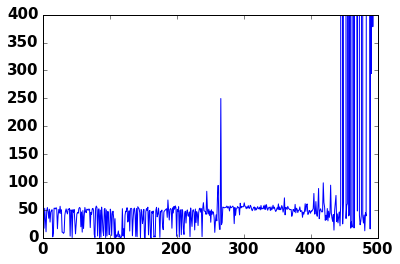

In [120]:
plt.plot(range(0,len(p_and_a_ctg_blast_cov_df)),p_and_a_ctg_blast_cov_df.sort_values(by=[ 'P_contig','ID'])['Average Coverage PacBio'] )
plt.ylim(0,400)

In [121]:
set(High_PacBio_coverage_300["ID"].tolist())

{'000180F',
 '000181F',
 '000184F',
 '000185F',
 '000186F',
 '000190F',
 '000195F',
 '000202F',
 '000203F',
 '000208F',
 '000209F',
 '000211F',
 '000212F',
 '000216F',
 '000217F',
 '000224F',
 '000237F',
 '000242F',
 '000243F',
 '000247F',
 '000248F',
 '000253F',
 '000255F',
 '000256F',
 '000257F'}

In [122]:
mitoch_df = tc_blast_search_df(blast_xml_path, blast_xml_file_name, p_and_a_ctg_df["ID"].tolist(), 'mitoch')

In [123]:
above_200_cov_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, above_200_cov["ID"].tolist())

In [124]:
!pwd

/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip


In [125]:
#26 congtigs are p, 2 are h, and only hit mitoch and ribosomal RNA
above_200_cov_blast_df.to_csv(blast_xml_path+'/v8_1_ph_tr_above_200_cov_blast.csv')

In [126]:
below_200_cov["ID"].count()

467

In [127]:
above_200_cov["ID"].count()

28

In [128]:
p_and_a_ctg_blast_cov_df["ID"].count()

495

In [129]:
below_200_cov.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Bangiophyceae,Tsukubamonadidae,Thermotogae,delta/epsilon subdivisions,...,environmental samples,Archaea,Bacteria,Eukaryota,synthetic construct,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
0,000000F,3534678,44.149283,v8_1_ph_tr_ctg.fa,1,0,0,0,0,0,...,1,0,0,892,0,893,99.89,000000F,54.980,59.363
1,000000F_002,310052,43.811038,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,59,0,59,100.00,000000F,52.731,57.596
2,000000F_003,112863,43.687480,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,42.856,50.840
3,000000F_004,27485,42.517737,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,17.175,38.320
4,000000F_005,333604,44.459599,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,744,0,744,100.00,000000F,52.828,55.279


In [130]:
#get all contigs with haplotigs
p_w_h_list = list(set(below_200_cov[(below_200_cov['P_contig'] == 0)]['P_ID']))

In [131]:
#get all contigs without haplotigs
p_wo_h_list =  list(set(below_200_cov[below_200_cov['P_contig'] ==1]['ID']) - set(p_w_h_list))

In [132]:
p_and_a_ctg_blast_cov_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Bangiophyceae,Tsukubamonadidae,Thermotogae,delta/epsilon subdivisions,...,environmental samples,Archaea,Bacteria,Eukaryota,synthetic construct,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina
0,000000F,3534678,44.149283,v8_1_ph_tr_ctg.fa,1,0,0,0,0,0,...,1,0,0,892,0,893,99.89,000000F,54.980,59.363
1,000000F_002,310052,43.811038,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,59,0,59,100.00,000000F,52.731,57.596
2,000000F_003,112863,43.687480,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,42.856,50.840
3,000000F_004,27485,42.517737,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,17,0,17,100.00,000000F,17.175,38.320
4,000000F_005,333604,44.459599,v8_1_ph_tr_ctg.fa,0,1,0,0,0,0,...,0,0,0,744,0,744,100.00,000000F,52.828,55.279


In [133]:
total_seq_recs = 0
p_w_h_contigs =[]
p_wo_h_contigs = []
pwh_count =0
pwoh_count =0
for seq_record in SeqIO.parse(p_and_a_ctg_path+'/'+p_and_a_ctg_file_name, "fasta"):
    if seq_record.id in p_w_h_list:
        p_w_h_contigs.append(seq_record)
        pwh_count += 1
    if seq_record.id in p_wo_h_list:
        p_wo_h_contigs.append(seq_record)
        pwoh_count += 1
    total_seq_recs += 1
len(below_200_cov[below_200_cov['P_contig']==1]['ID']) == pwh_count + pwoh_count

True

In [134]:
SeqIO.write(p_wo_h_contigs,p_and_a_ctg_file_name[0:(len(p_and_a_ctg_file_name)-3)]+'_pwoh_ctg.fa' , 'fasta')

113

In [135]:
SeqIO.write(p_w_h_contigs,p_and_a_ctg_file_name[0:(len(p_and_a_ctg_file_name)-3)]+'_pwh_ctg.fa' , 'fasta')

87

In [136]:
nucmer_dir ='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v8_1/v8_1_unzip/QC_unpolished/nucmer/'

In [137]:
for seq in SeqIO.parse(p_and_a_ctg_file_name[0:(len(p_and_a_ctg_file_name)-3)]+'_pwoh_ctg.fa', 'fasta'):
    SeqIO.write(seq, nucmer_dir+seq.id+".fa", 'fasta')

In [138]:
SeqIO.write(p_w_h_contigs,nucmer_dir+p_and_a_ctg_file_name[0:(len(p_and_a_ctg_file_name)-3)]+'_pwh_ctg.fa' , 'fasta')
SeqIO.write(p_wo_h_contigs,nucmer_dir+p_and_a_ctg_file_name[0:(len(p_and_a_ctg_file_name)-3)]+'_pwoh_ctg.fa' , 'fasta')

113

In [139]:
#initiate nucmer bash script writting
bash_script="v8_1_ph_p_on_p_nucmer.sh"

In [140]:
os.chdir(nucmer_dir)
outf = open(bash_script, 'w')
outf.write('#!/bin/bash\n')

12

In [141]:
p_w_h_contigs_fn = p_and_a_ctg_file_name[0:(len(p_and_a_ctg_file_name)-3)]+'_pwh_ctg.fa'

In [142]:
for seq in SeqIO.parse(p_and_a_ctg_file_name[0:(len(p_and_a_ctg_file_name)-3)]+'_pwoh_ctg.fa', 'fasta'):
        outf.write('nucmer '+p_w_h_contigs_fn+' '+seq.id+".fa > "+'out.delta\n')
        outf.write('delta-filter -g '+'out.delta'+" > "+seq.id+"_gfiltered.delta\n")
        outf.write('show-coords -T '+seq.id+"_gfiltered.delta > "+seq.id+".gcoords\n")
outf.close()

In [147]:
#get all haplcontigs that are not mitochondrial
h_list = list(set(below_200_cov[(below_200_cov['A_contig'] == 1)]['ID']))

In [149]:
len(h_list)

267

In [162]:
total_seq_recs = 0
h_contigs =[]
h_contigs_plus_200=[]
h_count =0
for seq_record in SeqIO.parse(p_and_a_ctg_path+'/'+p_and_a_ctg_file_name, "fasta"):
    if seq_record.id in h_list:
        h_contigs.append(seq_record)
        h_count += 1
    if '_' in list(seq_record.id) and seq_record.id not in h_list:
        h_contigs_plus_200.append(seq_record)
    total_seq_recs += 1

In [163]:
SeqIO.write(h_contigs,p_and_a_ctg_file_name[0:(len(p_and_a_ctg_file_name)-3)]+'_h_ctg.fa' , 'fasta')

267

In [164]:
SeqIO.write(h_contigs_plus_200,p_and_a_ctg_file_name[0:(len(p_and_a_ctg_file_name)-3)]+'_h_ctg_plus_200.fa' , 'fasta')

2